# Examining cross-correlation 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In this exercise, we will investigate cross-correlation between three stochastic processes. Our first two processes will be completely independent random walks:

$ x_t = x_{t-1} + ε_{x,t} $ 

$ y_t = y_{t-1} + ε_{y,t} $

Where $ ε_{\cdot,t} \sim \mathcal{N}(0,1)$. The two processes $x_t$ and $y_t$ are independent and should not be correlated in any way.

We'll also introduce a third process, which is dependent on $ x_t $ and $ y_t $:

$ z_t = z_{t-1} + 2x_{t-5} + y_{t-10} + ε_{z,t} $

<Axes: >

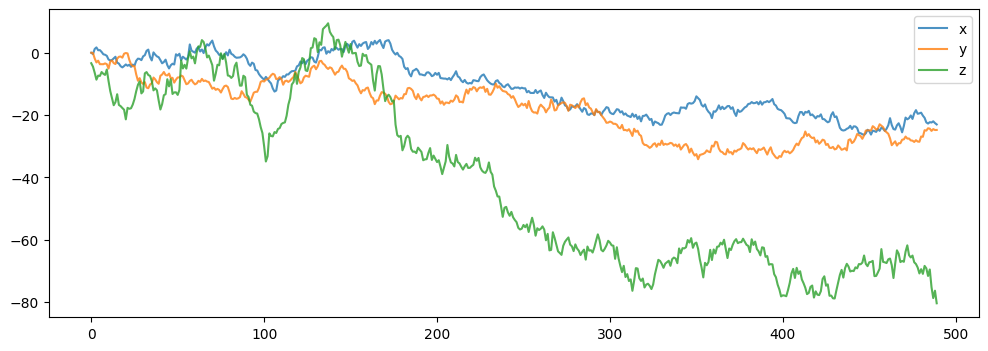

In [2]:
# Set random seed for reproducibility
np.random.seed(2)

# Generate random walk processes
N = 500

# Create the three independent random walks in an Nx3 numpy array
rw = np.zeros((N,3))
for t in range(N-1):
    rw[t+1,:] = rw[t,:] + np.random.normal(size=3)

# Add correlation to the third process
rw[:-10,2] = rw[:-10,2] + 2*rw[5:-5,0]  + 1*rw[10:,1]
rw = rw[:-10,:]  # Align lengths

# Create a dataframe from the array
df = pd.DataFrame({
    'x': rw[:,0],
    'y': rw[:,1],
    'z': rw[:,2]
})

# Plot the random walks
df.plot(alpha=0.8, figsize=(12, 4))


🔎 Plot the cross-correlation of the three random processes, using `plot_ccf` from `statsmodels`

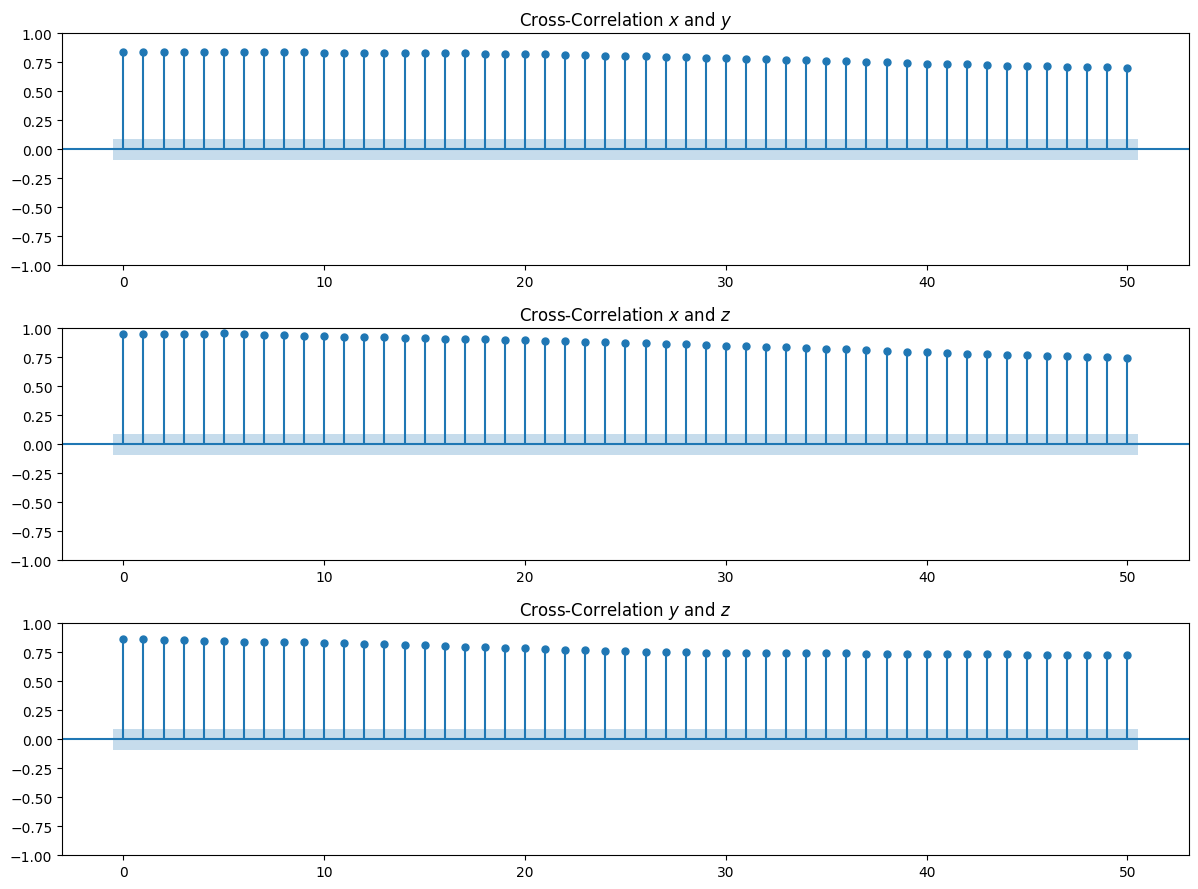

In [3]:
from statsmodels.graphics.tsaplots import plot_ccf
max_lags = 50
fig, ax = plt.subplots(3, 1, figsize=(12, 9))

plot_ccf(df['x'], df['y'], lags=max_lags, ax=ax[0])
ax[0].set_title('Cross-Correlation $x$ and $y$')

# <------ Add your code here, to plot the cross-correlations of x and z, and y and z
### ANSWER
plot_ccf(df['x'], df['z'], lags=max_lags, ax=ax[1])
ax[1].set_title('Cross-Correlation $x$ and $z$')
plot_ccf(df['y'], df['z'], lags=max_lags, ax=ax[2])
ax[2].set_title('Cross-Correlation $y$ and $z$')
plt.tight_layout()
plt.show()

🔎 The CCF shows significant cross-correlation throughout. Let's try pre-whitening the stochastis processes, then calculate the CCF again. We can pre-whiten the process by fitting a simple AR(1) model (using `AutoReg`) to $ x $, the using the same model to calculate the residuals on each process. 

What do you notice about the filtered CCF?

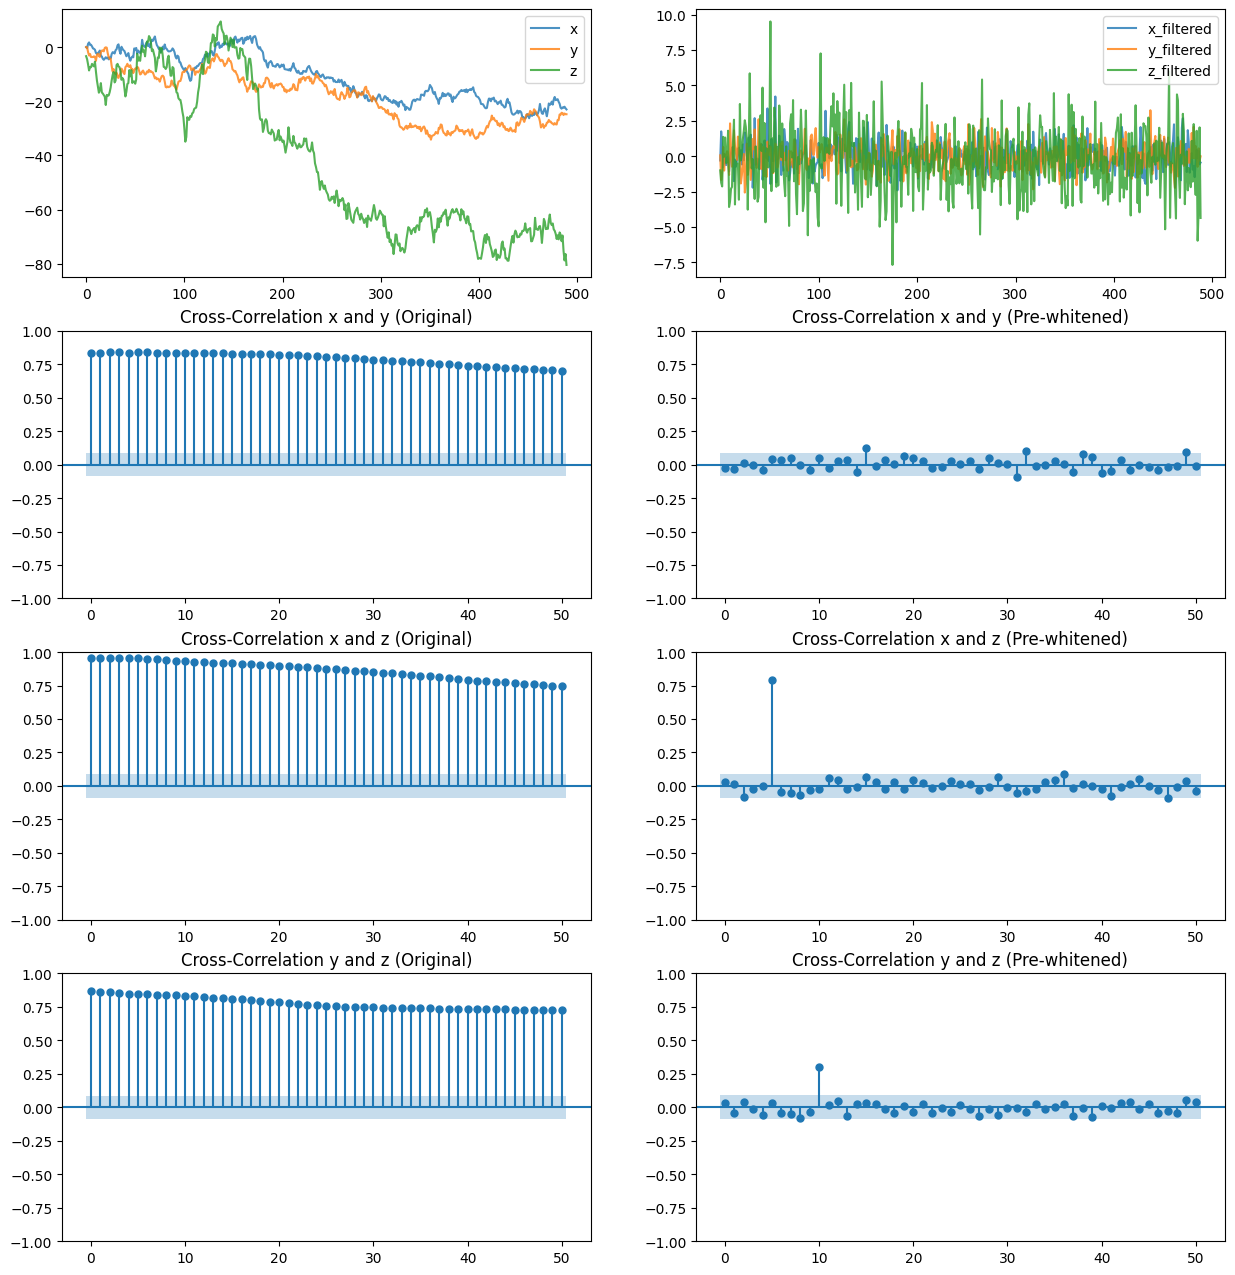

In [5]:
# Pre-whitening using AR(1) model
from statsmodels.tsa.ar_model import AutoReg

# Fit AR(1) model to x and pre-whiten
AR1 = AutoReg(df['x'], lags=1).fit()
x_filtered = df['x'][1:].values - AR1.params['x.L1'] * df['x'][:-1].values - AR1.params['const'] 
# You could use "x_filtered = AR1.resid", but this way makes the implementation for pre-whitening y and z clearer

# <----- Apply the same AR(1) filter to y and z using the fitted parameters
y_filtered = df['y'][1:].values - AR1.params['x.L1'] * df['y'][:-1].values - AR1.params['const']  ### ANSWER
z_filtered = df['z'][1:].values - AR1.params['x.L1'] * df['z'][:-1].values - AR1.params['const']  ### ANSWER

# <----- Create DataFrame with filtered series
### ANSWER
df_filtered = pd.DataFrame({
    'x_filtered': x_filtered,
    'y_filtered': y_filtered,
    'z_filtered': z_filtered
})

# <------ Plot original vs filtered series
### ANSWER
fig, ax = plt.subplots(4, 2, figsize=(15, 16))
df.plot(alpha=0.8, ax = ax[0, 0])
df_filtered.plot(alpha=0.8, ax = ax[0, 1])

# <------- Plot cross-correlations of original and filtered series
### ANSWER
combinations = [('x', 'y'), ('x', 'z'), ('y', 'z')]
for i, (var1, var2) in enumerate(combinations, start=1):
    plot_ccf(df[var1], df[var2], lags=max_lags, ax=ax[i,0])
    ax[i, 0].set_title(f'Cross-Correlation {var1} and {var2} (Original)')
    plot_ccf(df_filtered[f'{var1}_filtered'], df_filtered[f'{var2}_filtered'], lags=max_lags, ax=ax[i,1])
    ax[i, 1].set_title(f'Cross-Correlation {var1} and {var2} (Pre-whitened)')
    